In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.jet()

import sys
sys.path.insert(0, '../')
from M1S_tools import *

import matplotlib.animation as animation
from scipy.interpolate import griddata

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
## bending modes & influence matrices etc from Buddy #####################
ML actuators =  165 165
Afn =  (6991, 165)
fv =  (165, 165)
U matrix (6991, 165)
N node =  6991
## bending modes & influence matrices etc from Trupti #####################
N actuators =  170
/Users/bxin/Library/CloudStorage/OneDrive-SharedLibraries-GMTOCorp/M1S Portal - Documents/influnce_matrix_files/OA_influence_matrices_all/OA_surface_normal_165SA_09Jan2025/
Afz =  (27547, 165)
U matrix (27547, 165)
S matrix (165, 165)

<Figure size 640x480 with 0 Axes>

In [102]:
#starting from a few hours before turning on the suckulators
#ending a few hours after turning on the suckulators
import time
from datetime import datetime
if 0:
    #current unix timestamp
    #not more than 1 day. it will mess up the time label on our plots (we only mark hh:mm)
    start_time = time.time()-24*3600 
    end_time = time.time()
    dateID = datetime.fromtimestamp(start_time).strftime('%Y%m%d')[2:]
if 1:
    dateID = '250226'
    start_time = datetime.strptime('20'+dateID+'00:00:00', "%Y%m%d%H:%M:%S").timestamp()
    end_time = start_time + 24*3600
duration = end_time - start_time

In [103]:
inputfile = '../ml_data_interface/m1s3_tc_20241209.txt'
df = pd.read_csv(inputfile, skiprows=14, nrows=154)
df
#verify that table below is 1 row more than what we need

,HEADER,Name,X,Y,Which_Scanner,Scanner_channel,Scanner_Index,Valid,Offset
0,DATA,TC1REF,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
1,DATA,MTCIN002B,-0.332903,-0.474510,0.0,1.0,0.0,1.0,0.0
2,DATA,MTCIN002M,-0.332903,-0.474510,0.0,2.0,0.0,1.0,0.0
3,DATA,MTCIN002F,-0.332892,-0.384404,0.0,3.0,0.0,1.0,0.0
4,DATA,MTC013B,-1.742551,-1.198263,0.0,4.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
149,DATA,CTCAA003,0.000000,0.000000,5.0,24.0,5.0,1.0,0.0
150,DATA,CTCCW003W,0.000000,0.000000,5.0,25.0,5.0,1.0,0.0
151,DATA,CTCCW003F,0.000000,0.000000,5.0,26.0,5.0,1.0,0.0
152,DATA,CTCIB006,0.000000,0.000000,5.0,31.0,5.0,1.0,0.0


In [104]:
# Remove the last row
df = df.iloc[:-1]

In [105]:
# Remove leading and trailing spaces from column names
df.columns = df.columns.str.strip()
# Step 2: Remove leading/trailing spaces from all string values in the DataFrame
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

In [106]:
df

,HEADER,Name,X,Y,Which_Scanner,Scanner_channel,Scanner_Index,Valid,Offset
0,DATA,TC1REF,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
1,DATA,MTCIN002B,-0.332903,-0.474510,0.0,1.0,0.0,1.0,0.0
2,DATA,MTCIN002M,-0.332903,-0.474510,0.0,2.0,0.0,1.0,0.0
3,DATA,MTCIN002F,-0.332892,-0.384404,0.0,3.0,0.0,1.0,0.0
4,DATA,MTC013B,-1.742551,-1.198263,0.0,4.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
148,DATA,CTCUP012,0.000000,0.000000,5.0,23.0,5.0,1.0,0.0
149,DATA,CTCAA003,0.000000,0.000000,5.0,24.0,5.0,1.0,0.0
150,DATA,CTCCW003W,0.000000,0.000000,5.0,25.0,5.0,1.0,0.0
151,DATA,CTCCW003F,0.000000,0.000000,5.0,26.0,5.0,1.0,0.0


In [107]:
#these indices are based on the above txt file. 
#They are shorter than those indices without the "1". The latter are defined in M1S_tools.py
#Those without "1" can be used to index the arrays read from the DB

# Logical index for rows with 'Name' starting with "MTC" and ending with "F"
idx_mirror_f1 = df['Name'].str.startswith('MTC') & df['Name'].str.endswith('F')
print('number of Mirror Front surface TCs = ', sum(idx_mirror_f1))
# Display the logical index
idx_mirror_b1 = df['Name'].str.startswith('MTC') & df['Name'].str.endswith('B')
print('number of Mirror Back surface TCs = ', sum(idx_mirror_b1))
idx_mirror_m1 = df['Name'].str.startswith('MTC') & df['Name'].str.endswith('M')
print('number of Mirror Middle TCs = ', sum(idx_mirror_m1))
idx_rtd1 = df['Name'].str.startswith('TC') & df['Name'].str.endswith('REF')
print('number of RTDs = ', sum(idx_rtd1))

number of Mirror Front surface TCs =  48
number of Mirror Back surface TCs =  48
number of Mirror Middle TCs =  16
number of RTDs =  6


In [108]:
df['Name'][1]

'MTCIN002B'

In [109]:
print(len(idx_mirror_b),len(idx_mirror_b1))
#b1 is what we read from the txt above. b has dimension that matches the arrays we read out from the DB

192 153


(-4.4914386, 4.4914386, -4.4902649, 4.4902649)

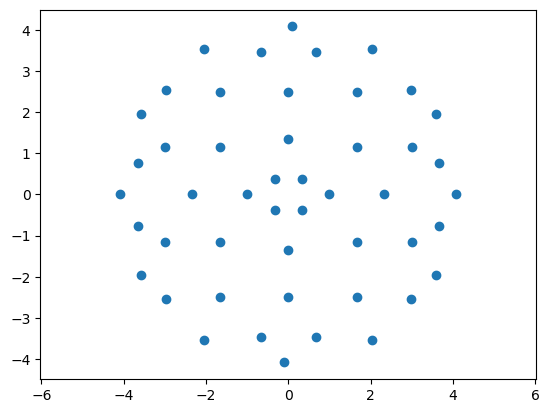

In [110]:
plt.scatter(df['X'][idx_mirror_f1], df['Y'][idx_mirror_f1])
plt.axis('equal')

(-4.590848899999999, 4.590848899999999, -4.5896587, 4.5896587)

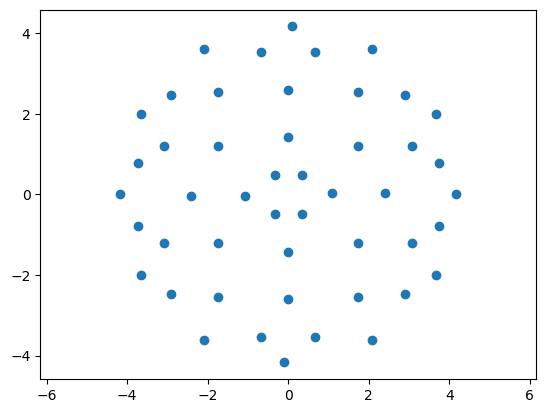

In [111]:
plt.scatter(df['X'][idx_mirror_b1], df['Y'][idx_mirror_b1])
plt.axis('equal')

(-4.590848899999999, 4.590848899999999, -4.5896587, 4.5896587)

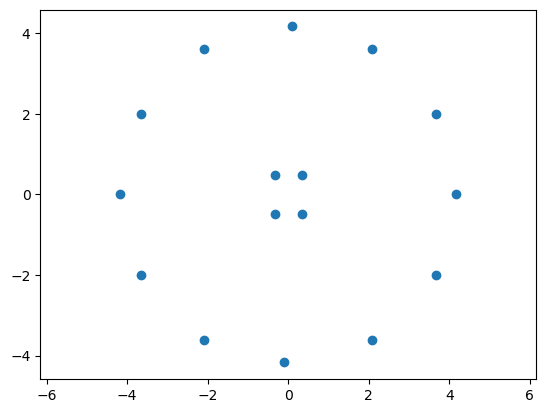

In [112]:
plt.scatter(df['X'][idx_mirror_m1], df['Y'][idx_mirror_m1])
plt.axis('equal')

In [113]:
nsamples = 480
tc, tt = getDBData(start_time,'m1_s1_thermal_ctrl/i/tc_temperature/value', duration_in_s=duration, samples=nsamples)

m1_s1_thermal_ctrl/i/tc_temperature/value
2025-02-26 00:00:00  duration =  86400.0  s
(480, 192)


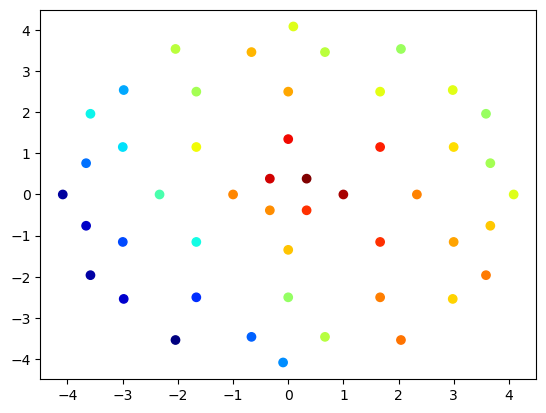

In [114]:
plt.scatter(tc_locs[idx_mirror_f,0], tc_locs[idx_mirror_f,1], c = tc[0,idx_mirror_f])

In [115]:
len(idx_mirror_f)
# https://github.com/CanisUrsa/ocs_m1_dcs/blob/master/src/etc/conf/m1_thermal_pkg/common/m1_s3_tc_position_conf.coffee
# https://github.com/CanisUrsa/ocs_m1_dcs/blob/master/src/etc/conf/m1_thermal_pkg/common/m1_s3_tc_label_conf.coffee

192

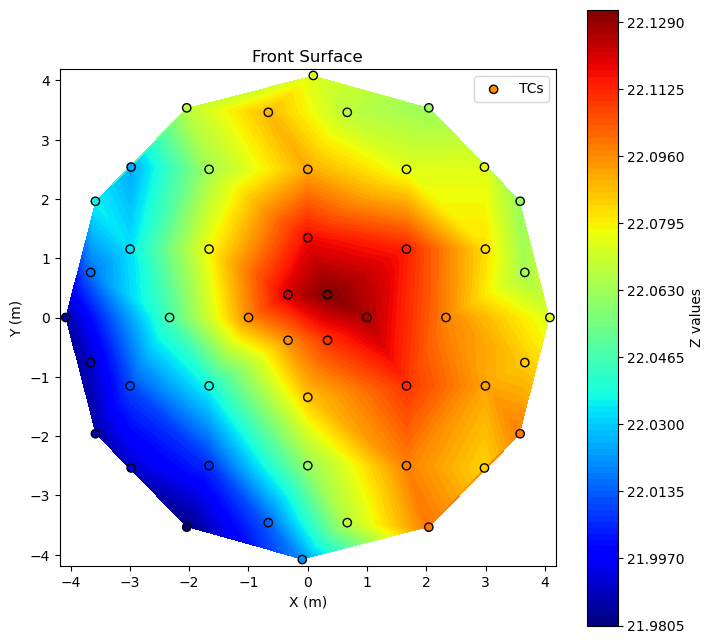

In [116]:
x = tc_locs[idx_mirror_f][:,0] 
y = tc_locs[idx_mirror_f][:,1]
z = tc[0,idx_mirror_f]

# Define the grid for interpolation
grid_size = 500  # Resolution of the grid
xi = np.linspace(-radius_of_CA, radius_of_CA, grid_size)
yi = np.linspace(-radius_of_CA, radius_of_CA, grid_size)
xi, yi = np.meshgrid(xi, yi)

# Create a circular mask for the given radius
mask = np.sqrt(xi**2 + yi**2) <= radius_of_CA

# Interpolate z-values to the grid
zi = griddata((x, y), z, (xi, yi), method='linear')

# Apply the circular mask
zi[~mask] = np.nan  # Set values outside the circle to NaN

# Plot the result
plt.figure(figsize=(8, 8))
contour = plt.contourf(xi, yi, zi, levels=100, cmap='jet')
plt.colorbar(contour, label='Z values')
plt.scatter(x, y, c=z, edgecolor='k', cmap='jet', label='TCs')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Front Surface')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.legend()
plt.show()

In [117]:
#tmirror, tt = getDBData(start_time,'m1_s1_thermal_ctrl/i/mirror_temperature/value', duration_in_s=duration, samples=nsamples)
tambient, tt = getDBData(start_time,'m1_s1_thermal_ctrl/i/ambient_temperature/value', duration_in_s=duration, samples=nsamples)

time_steps = tc.shape[0]  # Number of time steps

# Define the grid for interpolation
grid_size = 500  # Resolution of the grid
xi = np.linspace(-radius_of_CA, radius_of_CA, grid_size)
yi = np.linspace(-radius_of_CA, radius_of_CA, grid_size)
xi, yi = np.meshgrid(xi, yi)

# Create a circular mask for the given radius
mask = np.sqrt(xi**2 + yi**2) <= radius_of_CA

# Set the fixed color limits (vmin, vmax) for the contour plot
tc[tc>30] = np.nan
tc[tc<10] = np.nan
vmin = np.nanmin(tambient)  # Minimum value for the colorbar
vmax = np.nanmax(tambient) #mirror)  # Maximum value for the colorbar
#levels = np.linspace(vmin, vmax, 100)  # Explicitly define levels
vmax_index = np.nanargmax(tambient) #tmirror)
tt0 = tt[vmax_index]
#print('vmin, vmax, ==== ', vmin, vmax)
cbar_span = 0.4 #deg

m1_s1_thermal_ctrl/i/ambient_temperature/value
2025-02-26 00:00:00  duration =  86400.0  s
(480,)


In [118]:
tambient.shape

(480,)

In [119]:
idxfo = np.sqrt(tc_locs[idx_mirror_f,0]**2+tc_locs[idx_mirror_f,1]**2) > 4
idxfi = np.sqrt(tc_locs[idx_mirror_f,0]**2+tc_locs[idx_mirror_f,1]**2) < 1
idxbo = np.sqrt(tc_locs[idx_mirror_b,0]**2+tc_locs[idx_mirror_b,1]**2) > 4
idxbi = np.sqrt(tc_locs[idx_mirror_b,0]**2+tc_locs[idx_mirror_b,1]**2) < 1

In [120]:
def update_plot(frame):

    if hasattr(update_plot, 'timeline'):
        update_plot.timeline.remove()
    #update_plot.timeline = ax1.axvline(x=(tt[frame]-tt0)/3600., color='r', linestyle='--', label='Current Time')
    update_plot.timeline = ax1.axvline(x=frame, color='g', linestyle='--')#, label='Current Time')
    
    if hasattr(update_plot, 'timeline2'):
        update_plot.timeline2.remove()
    update_plot.timeline2 = ax2.axvline(x=frame, color='g', linestyle='--')#, label='Current Time')
    
    ax1.set_title(f'Day = {dateID}, Current Time (green dashed) = {datetime.fromtimestamp(tt[frame]).strftime("%H:%M")}', fontsize=10)

    # Get the data for the current time step
    x = tc_locs[idx_mirror_f][:,0]
    y = tc_locs[idx_mirror_f][:,1]
    z = tc[frame, idx_mirror_f]  # Extract z-values for the current time step

    # Interpolate z-values to the grid
    zi = griddata((x, y), z, (xi, yi), method='linear')

    # Apply the circular mask
    zi[~mask] = np.nan  # Set values outside the circle to NaN

    midpoint = np.nanmean(zi)
    levels = np.linspace(midpoint-cbar_span/2., midpoint+cbar_span/2., 100)
    zi = np.clip(zi, np.min(levels), np.max(levels))

    #ax3 for front
    ax3.clear()
    x = tc_locs[idx_mirror_f][:,0]
    y = tc_locs[idx_mirror_f][:,1]
    z = tc[frame, idx_mirror_f]
    zi = griddata((x, y), z, (xi, yi), method='linear')
    zi[~mask] = np.nan  # Set values outside the circle to NaN

    midpoint = np.nanmean(zi)
    levels = np.linspace(midpoint-cbar_span/2., midpoint+cbar_span/2., 100)
    zi = np.clip(zi, np.min(levels), np.max(levels))

    contour = ax3.contourf(xi, yi, zi, levels=levels, cmap='jet')
    ax3.set_aspect('equal', adjustable='box')
    ax3.set_title('Front, Max - Min = %.2f Deg'%(np.nanmax(zi)-np.nanmin(zi)), fontsize=10)
    ax3.set_xlabel('X (m)')
    ax3.set_ylabel('Y (m)')
    if hasattr(update_plot, 'cbar3'):
        update_plot.cbar3.remove()
    update_plot.cbar3 = fig.colorbar(contour, ax=ax3, format='%.2f')#, label='Temperature')  # Store the colorbar
    ax3.scatter(x, y, c=z, edgecolor='k', vmin=np.min(levels), vmax=np.max(levels), cmap='jet', label='TCs')
    #ax3.legend(loc='upper right')

    #ax4 for back
    ax4.clear()
    x = tc_locs[idx_mirror_b][:,0]
    y = tc_locs[idx_mirror_b][:,1]
    z = tc[frame, idx_mirror_b]
    zi = griddata((x, y), z, (xi, yi), method='linear')
    zi[~mask] = np.nan  # Set values outside the circle to NaN

    midpoint = np.nanmean(zi)
    levels = np.linspace(midpoint-cbar_span/2., midpoint+cbar_span/2., 100)
    zi = np.clip(zi, np.min(levels), np.max(levels))

    contour = ax4.contourf(xi, yi, zi, levels=levels, cmap='jet')
    ax4.set_aspect('equal', adjustable='box')
    ax4.set_title('Back, Max - Min = %.2f Deg'%(np.nanmax(zi)-np.nanmin(zi)), fontsize=10)
    ax4.set_xlabel('X (m)')
    #ax4.set_ylabel('Y (m)')
    if hasattr(update_plot, 'cbar4'):
        update_plot.cbar4.remove()
    update_plot.cbar4 = fig.colorbar(contour, ax=ax4, format='%.2f')#, label='Temperature')  # Store the colorbar
    ax4.scatter(x, y, c=z, edgecolor='k', cmap='jet', vmin=np.min(levels), vmax=np.max(levels), label='TCs')
    #ax4.legend(loc='upper right')

    #ax5 for back-front
    ax5.clear()
    x = tc_locs[idx_mirror_b][:,0]
    y = tc_locs[idx_mirror_b][:,1]
    z = tc[frame, idx_mirror_b] - tc[frame, idx_mirror_f]
    zi = griddata((x, y), z, (xi, yi), method='linear')
    zi[~mask] = np.nan  # Set values outside the circle to NaN

    midpoint = np.nanmean(zi)
    levels = np.linspace(midpoint-cbar_span/2., midpoint+cbar_span/2., 100)
    zi = np.clip(zi, np.min(levels), np.max(levels))

    contour = ax5.contourf(xi, yi, zi, levels=levels, cmap='jet')
    ax5.set_aspect('equal', adjustable='box')
    ax5.set_title('Back-Front, Max - Min = %.2f Deg'%(np.nanmax(zi)-np.nanmin(zi)), fontsize=10)
    ax5.set_xlabel('X (m)')
    #ax5.set_ylabel('Y (m)')
    if hasattr(update_plot, 'cbar5'):
        update_plot.cbar5.remove()
    update_plot.cbar5 = fig.colorbar(contour, ax=ax5, format='%.2f')#, label='Temperature')  # Store the colorbar
    ax5.scatter(x, y, c=z, edgecolor='k', cmap='jet', vmin=np.min(levels), vmax=np.max(levels), label='TCs')
    #ax5.legend(loc='upper right')
    
    # Redraw the figure
    plt.draw()

In [121]:
np.mean(tc[:,idx_mirror_f], axis=1).shape

(480,)

In [122]:
tt[1:5]-tt[:4]

array([179.99986196, 180.00013971, 179.99995351, 180.00004697])

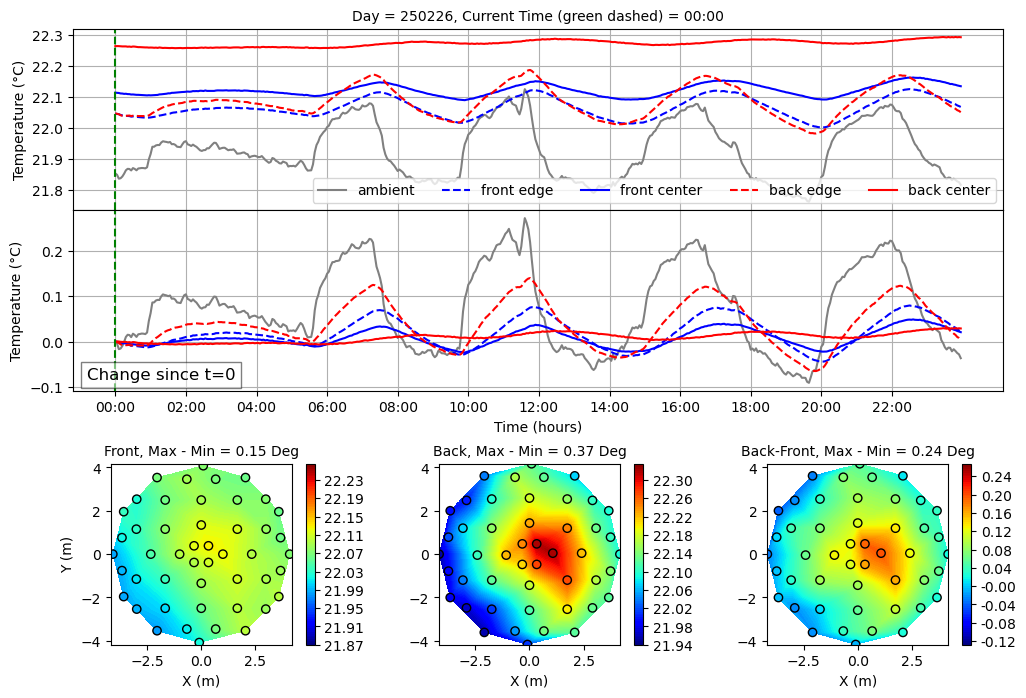

In [123]:
# Create the figure and axis for the subplots (2 panels)
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))  # **Create 2 subplots: left (ax1) for tmirror, right (ax2) for contour plot**
#fig.subplots_adjust(hspace=0.4, wspace=0.3)
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(12)

ax1 = plt.subplot2grid(shape=(3, 3), loc=(0,0), colspan=3) # deg C
ax2 = plt.subplot2grid(shape=(3, 3), loc=(1,0), colspan=3, sharex=ax1) #2D, deg C
ax3 = plt.subplot2grid(shape=(3, 3), loc=(2,0)) #front
ax4 = plt.subplot2grid(shape=(3, 3), loc=(2,1)) #back
ax5 = plt.subplot2grid(shape=(3, 3), loc=(2,2)) #back-front
plt.subplots_adjust(hspace=0.2)  # Reduce space between rows
ax1.label_outer()
# Manually shift ax2 up to remove gap with ax1
pos1 = ax1.get_position()  # Get original position
pos2 = ax2.get_position()
ax2.set_position([pos2.x0, pos1.y0 - pos1.height, pos2.width, pos2.height])  # Move ax2 up

# Plot the tmirror on ax1
time_labels = [datetime.fromtimestamp(ts).strftime('%H:%M') for ts in tt]
ax1.plot(time_labels,  tambient, 'grey', label='ambient')
ax1.plot(time_labels, np.mean(tc[:,idx_mirror_f][:,idxfo], axis=1), '--b', label='front edge')
ax1.plot(time_labels, np.mean(tc[:,idx_mirror_f][:,idxfi], axis=1), '-b', label='front center')
ax1.plot(time_labels, np.mean(tc[:,idx_mirror_b][:,idxbo], axis=1), '--r', label='back edge')
ax1.plot(time_labels, np.mean(tc[:,idx_mirror_b][:,idxbi], axis=1), '-r', label='back center')
ax1.legend(ncol=5) #, framealpha=0.7)

#ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Temperature (°C)')
#ax1.set_ylim(min(tambient)-0.2*(vmax-vmin), max(tmirror)+0.2*(vmax-vmin))  # Adjust y-axis based on your data
timeline = ax1.axvline(x=0, color='g', linestyle='--') #, label='Current Time')
ax1.legend(loc='lower right', ncol=6)
timeline.remove()
ax1.grid()
oneEveryHowManyHours = 2
numToSkip = int(nsamples//(duration/3600/oneEveryHowManyHours))
ax1.set_xticks(ticks=np.arange(0, len(time_labels), step=numToSkip), labels=[time_labels[i] for i in range(0, len(time_labels), numToSkip)])

## Plot the temperature change since t=0 on ax2
ax2.plot(time_labels,  tambient-tambient[0], 'grey', label='ambient')
aa = np.mean(tc[:,idx_mirror_f][:,idxfo], axis=1)
ax2.plot(time_labels, aa-aa[0], '--b', label='front edge')
aa = np.mean(tc[:,idx_mirror_f][:,idxfi], axis=1)
ax2.plot(time_labels, aa-aa[0], '-b', label='front center')
aa = np.mean(tc[:,idx_mirror_b][:,idxbo], axis=1)
ax2.plot(time_labels, aa-aa[0], '--r', label='back edge')
aa= np.mean(tc[:,idx_mirror_b][:,idxbi], axis=1)
ax2.plot(time_labels, aa-aa[0], '-r', label='back center')
ax2.text(0.015, 0.13, "Change since t=0", transform=ax2.transAxes,
           fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

ax2.set_xlabel('Time (hours)')
ax2.set_ylabel('Temperature (°C)')
#ax1.set_ylim(min(tambient)-0.2*(vmax-vmin), max(tmirror)+0.2*(vmax-vmin))  # Adjust y-axis based on your data
timeline2 = ax2.axvline(x=0, color='g', linestyle='--', label='Current Time')
#ax2.legend(loc='upper right')
timeline2.remove()
ax2.grid()
ax2.set_xticks(ticks=np.arange(0, len(time_labels), step=numToSkip), labels=[time_labels[i] for i in range(0, len(time_labels), numToSkip)])
#plt.tight_layout()

testing = 0
if testing:
    # Create the animation
    #for testing, 1 frame only, just to show the layout
    ani = animation.FuncAnimation(fig, update_plot, frames=1, repeat=False)
    #ani = animation.FuncAnimation(fig, update_plot, frames=10, repeat=False)
    #ani.save('tc_surface.mp4', writer='ffmpeg', fps=5)
else:
    ani = animation.FuncAnimation(fig, update_plot, frames=time_steps, repeat=False)
    # Save the animation as an MP4 file
    length_in_s = 15
    ani.save('tc_surface_%s.mp4'%dateID, writer='ffmpeg', fps=int(nsamples/length_in_s))  # Modify fps as needed

### Does the front and back TC's line up in x and y?

In [124]:
np.max(tc_locs[idx_mirror_b][:,0]-tc_locs[idx_mirror_f][:,0])

0.09037263799999984

In [125]:
np.max(tc_locs[idx_mirror_b][:,1]-tc_locs[idx_mirror_f][:,1])

0.09035846399999947

### Explore the location of other TCs

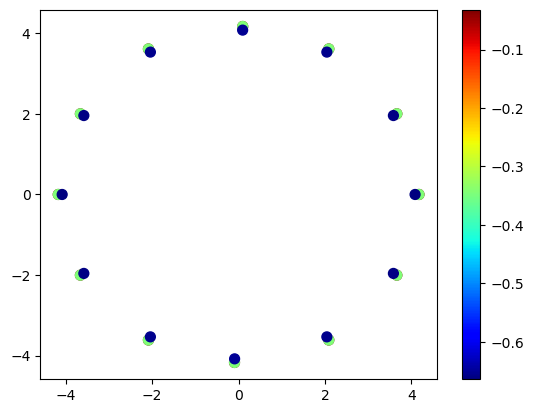

In [126]:
x = tc_locs[idx_mirror_ow][:,0] 
y = tc_locs[idx_mirror_ow][:,1]
z = tc_locs[idx_mirror_ow][:,2]
plt.scatter(x,y, 50, c=z)
plt.colorbar();

In [127]:
aa=np.array([0,0,0,0,           1,1,1,1,1,              -1,-1,-1,-1,-1])
bb=np.array([0.5,-0.5,0.5,-0.5, 1,1,1,1,1,              -1,-1,-1,-1,-1])
cc=np.array([0,0,0,0,           1.5,0.5,1.5,0.5,1,      -1,-1,-1,-1,-1])
print(np.sqrt(np.mean(aa**2) ), np.sqrt(np.mean(bb**2)), np.sqrt(np.mean(cc**2)) )

0.8451542547285166 0.8864052604279183 0.8864052604279183
